In [90]:
# load modules
import pickle, pdb, os, random, yaml, random, math, torch, math
from collections import OrderedDict
import numpy as np
import torch.nn as nn
from data_loader import get_loader, pathSpecDataset
from torch.utils.data import DataLoader
from vte_model import Vt_Embedder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
import pandas as pd
import seaborn as sns

In [2]:

results_dir = '/homes/bdoc3/phonDet/results'
spmel_path = '/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized'
model_name = 'newStandardAutovcSpmelParamsUnnormLatent64Out256'
model_path = os.path.join(results_dir, model_name)
config = pickle.load(open(model_path +'/config_params.pkl','rb'))
config.spmel_dir = config.data_dir

with open(spmel_path +'/spmel_params.yaml') as File:
    spmel_params = yaml.load(File, Loader=yaml.FullLoader)
    
emb_ckpt = model_path +'/best_epoch_checkpoint.pth.tar'

device = torch.device(f'cuda:{config.which_cuda}' if torch.cuda.is_available() else 'cpu')

config

Namespace(batch_size=128, chunk_num=6, chunk_seconds=0.5, ckpt_freq=100, config_file='', cuda=True, data_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', dropout=0.0, epochs=100, file_name='newStandardAutovcSpmelParamsUnnormLatent64Out256', is_blstm=True, iteration=1, load_ckpt='', lr=0.0001, lstm_num=2, model='choi_k2c2', n_mels=96, no_cuda=False, reg=0, seed=1, short=False, spmel_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', test_list='m2_ m10_ m3_ f2_ f4_', use_attention=False, which_cuda=0)

In [3]:
# run model
vte =  Vt_Embedder(config, spmel_params)
for param in vte.parameters():
    param.requires_grad = False
vte_optimizer = torch.optim.Adam(vte.parameters(), 0.0001)
vte_checkpoint = torch.load(emb_ckpt)
new_state_dict = OrderedDict()
for i, (key, val) in enumerate(vte_checkpoint['model_state_dict'].items()):
#     if key.startswith('class_layer'):
#         continue
    new_state_dict[key] = val
vte.load_state_dict(new_state_dict)

for state in vte_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda(which_cuda)

vte.to(device)
vte.eval()

# prep dataset
vocalSet = pathSpecDataset(config, spmel_params)
vocalSet_loader = DataLoader(vocalSet, batch_size=config.batch_size, shuffle=True, drop_last=False)

In [78]:


# infer embeddings
example_data = []
for i in range(5):
    try:
        x_real, style_idx, singer_idx = next(data_iter)
    except:
        data_iter = iter(vocalSet_loader)
        x_real, style_idx, singer_idx = next(data_iter)
    x_real = x_real.to(device)

    x_real_chunked = x_real.view(x_real.shape[0]*config.chunk_num, x_real.shape[1]//config.chunk_num, -1)
    pred_style_idx, all_tensors = vte(x_real_chunked)
    for j in range(len(x_real)):
        # last entry in example_data is a list of all embeddings for that example
        example_data.append((x_real[j], style_idx[j], singer_idx[j], pred_style_idx[j], [embs[j] for embs in all_tensors]))
    print(i)
embs = []
for i in range(len(example_data)):
    emb = example_data[i][-1][-1]
    emb_arr = emb.detach().cpu().numpy()
    embs.append(emb_arr)

0
1
2
3
4


In [79]:
embs[0]

array([0.        , 0.        , 0.        , 0.5841314 , 1.6974325 ,
       1.2445933 , 0.        , 0.62111247, 0.34182483, 0.6840552 ,
       0.        , 0.        , 0.10546822, 0.        , 0.        ,
       0.        , 0.        , 0.814527  , 0.9478329 , 0.        ,
       0.        , 0.        , 0.437092  , 0.        , 0.        ,
       0.00658039, 0.        , 1.6862649 , 0.13319425, 0.        ,
       0.12405922, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.6223753 , 1.2025499 , 0.03684664, 0.50352347,
       0.3933928 , 1.6538161 , 0.        , 0.23356767, 0.        ,
       0.20289096, 0.        , 0.        , 0.        , 0.10953627,
       0.        , 1.1103293 , 0.        , 0.        , 1.3754412 ,
       0.5452164 , 0.        , 0.19189402, 0.        , 1.9624264 ,
       2.1766899 , 0.        , 1.2564967 , 1.00377   , 0.        ,
       0.1385742 , 0.        , 0.        , 0.        , 0.4303372 ,
       0.        , 1.0206504 , 0.        , 0.7723324 , 0.     

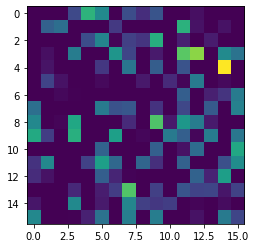

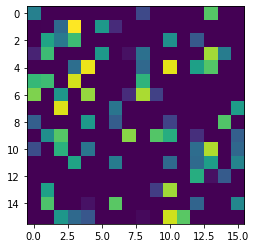

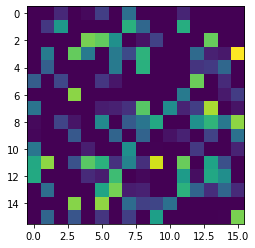

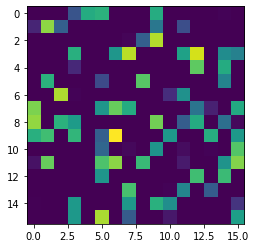

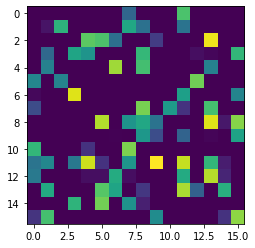

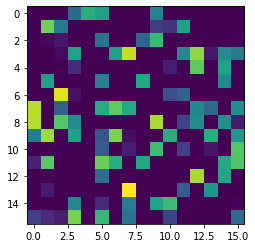

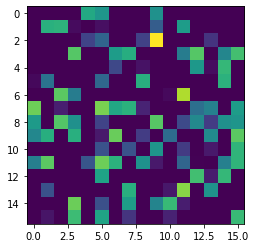

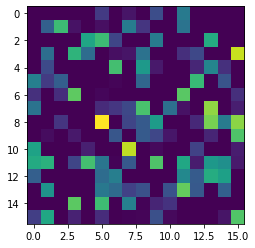

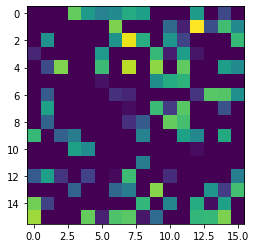

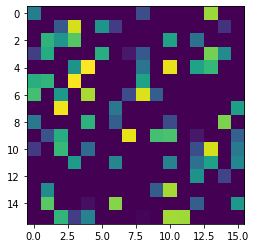

In [81]:
def tensor_to_matrix(array):
    sqr = int(math.sqrt(array.shape[0]))
    embs_mat = array.reshape((sqr,sqr))
    return embs_mat

# visualize data
for i in range(10):
    emb = tensor_to_matrix(embs[i])
    plt.figure()
    plt.imshow(emb)

In [82]:
type(embs[0])


numpy.ndarray

[68285.0859375]
[68285.0859375, 53774.08203125]
[68285.0859375, 53774.08203125, 41629.81640625]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625, 9730.052734375]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625, 9730.052734375, 9066.3798828125]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625, 9730.052734375, 9066.3798828125, 8435.9609375]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625, 9730.052734375, 9066.3798828125, 8435.9609375, 8014.0537109375]
[68285.0859375, 53774.08203125, 41629.81640625, 30152.34765625, 19834.513671875, 10603.9384765625, 9730.

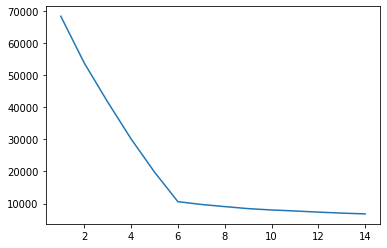

In [85]:
from sklearn.cluster import KMeans

# set up k_means clustering
k_range = range(1,11)
embs_array = np.asarray(embs)

sum_squared_error = []
for k_dim in k_range:    
    km = KMeans(n_clusters=k_dim)
    km.fit_predict(embs_array)
#    print(km.cluster_centers_.shape, km.cluster_centers_) 
    sum_squared_error.append(km.inertia_)
plt.plot(k_range, sum_squared_error)

In [88]:
hc = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage='ward')
hc_clustering = hc.fit_predict(embs)
hc_sil_score = silhouette_score(embs, hc_clustering, metric='euclidean')
hc_sil_score
# kmeans_cluster_accuracy = adjusted_rand_score(kmeans_cluster_list, rearranged_class_list)

0.59291023

<AxesSubplot:>

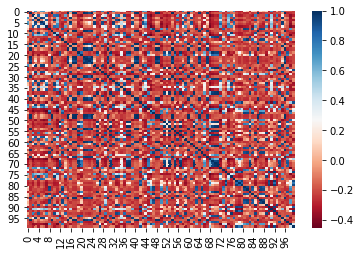

In [95]:
#convert to pandas dataframe
df = pd.DataFrame(embs[:100])
# swap axes
df_tran = df.T
# generate coorelation matrix for all columns
df_tran_corr = df_tran.corr('pearson')
sns.heatmap(df_tran_corr, cmap = "RdBu")